<a href="https://colab.research.google.com/github/TebaSUH/Counrties-Classification/blob/main/Copy_of_few_shot_captioning_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading and Spliting the dataset**

In [1]:
from datasets import load_dataset, DatasetDict

# 1. Load the dataset (it defaults to a single 'train' split with 833 images)
ds = load_dataset("reach-vb/pokemon-blip-captions")

# Access the 'train' split before selecting
ds_train = ds['train']

# 2. STRICT CONSTRAINT: Select only the first 700 images
# This discards everything after index 699.
ds_700 = ds_train.select(range(700))

# 3. Create the splits
# First, split off 20% (140 images) for validation+test, keeping 80% (560) for training.
# We use a seed to make sure the split is reproducible.
train_temp = ds_700.train_test_split(test_size=0.2, seed=42)

# Now, take that 20% chunk (which is currently called 'test') and split it in half
# This gives 10% for Validation and 10% for Test.
val_test = train_temp['test'].train_test_split(test_size=0.5, seed=42)

# 4. Reassemble into a clean DatasetDict
final_dataset = DatasetDict({
    'train': train_temp['train'],      # 560 images
    'validation': val_test['train'],   # 70 images
    'test': val_test['test']           # 70 images
})

# Verify the counts
print(final_dataset)
# Expected Output:
# DatasetDict({
#     train: Dataset({ num_rows: 560 ... }),
#     validation: Dataset({ num_rows: 70 ... }),
#     test: Dataset({ num_rows: 70 ... })
# })

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-566cc9b19d7203(…):   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 560
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 70
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 70
    })
})


**Plotting and visualizing**

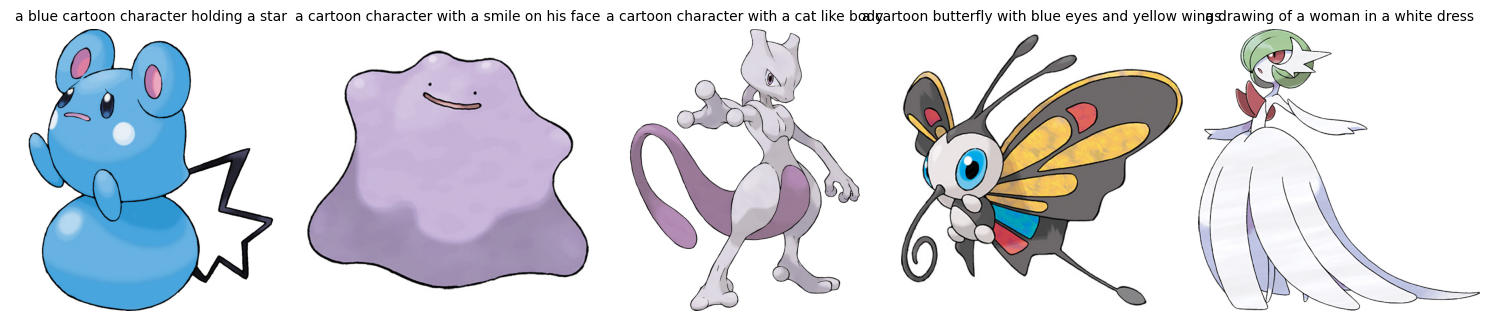

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

# Get a few examples from the training split
num_examples = 5
examples = final_dataset['train'].select(range(num_examples))

plt.figure(figsize=(15, 10))
for i, example in enumerate(examples):
    plt.subplot(1, num_examples, i + 1)
    image = example['image']
    caption = example['text']

    plt.imshow(image)
    plt.title(caption, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Loading processor**

In [3]:
from transformers import AutoProcessor

# Load the processor for Microsoft GIT
checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

**Preparing the data to the model**

In [4]:

def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]

    # Process images and text
    # padding="max_length" ensures all batches have the same shape
    inputs = processor(images=images, text=captions, padding="max_length")

    # Important: The model needs 'labels' to calculate loss
    # We copy the input_ids to use as labels
    inputs.update({"labels": inputs["input_ids"]})

    return inputs


# Apply the transformation to all three splits
final_dataset["train"].set_transform(transforms)
final_dataset["validation"].set_transform(transforms)
final_dataset["test"].set_transform(transforms)

In [5]:

from transformers import AutoModelForCausalLM, AutoProcessor
from peft import LoraConfig, get_peft_model, TaskType

# 1. Load the Model
checkpoint = "microsoft/git-base"
model = AutoModelForCausalLM.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

# 2. ENABLE GRADIENT CHECKPOINTING (The Magic Line)
# This saves massive memory by re-computing parts of the graph
#model.gradient_checkpointing_enable()

# 3. Define LoRA Config
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]
)

# 4. Apply LoRA
model = get_peft_model(model, peft_config)

# 5. Verify
model.print_trainable_parameters()
# Note: You might need to explicitly tell the model input requires grads
# because gradient checkpointing can sometimes disable it.
#model.enable_input_require_grads()

# 6. Trai

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

trainable params: 294,912 || all params: 176,913,978 || trainable%: 0.1667


In [ ]:
# from transformers import AutoModelForCausalLM

# checkpoint = "microsoft/git-base"
# model = AutoModelForCausalLM.from_pretrained(checkpoint)

# print("Freezing the vision encoder...")
# for param in model.git.image_encoder.parameters():
#     param.requires_grad = False
# print("Vision encoder frozen! (Memory usage will drop drastically)")

Freezing the vision encoder...
Vision encoder frozen! (Memory usage will drop drastically)


In [6]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00


In [7]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.7 MB/s eta 0:00:00


In [8]:

import evaluate

wer = evaluate.load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # The model outputs "logits" (raw scores). We pick the best one (argmax).
    predicted = logits.argmax(-1)

    # We must decode the numbers back into words to check accuracy
    # skip_special_tokens=True removes things like [PAD] and [CLS]
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)

    # Calculate the score
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)

    return {"wer_score": wer_score}

# **Triaining**

In [14]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="git-pokemon-700-finetuned",
    learning_rate=5e-5,
    num_train_epochs=20,
    fp16=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    eval_accumulation_steps=1,
    gradient_accumulation_steps=4,
    save_total_limit=2,
    eval_strategy="epoch",
    save_strategy="epoch",     # ⭐ ADD THIS
    logging_steps=100,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    report_to="none",
)



In [15]:
trainer = Trainer(
    model=model,
    args=training_args, # Ensure fp16=True is in your args
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["validation"],
    compute_metrics=None,
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,10.001130
2,10.491100,9.560593
3,9.630600,9.410259
4,9.630600,9.357250
5,9.475700,9.320635
6,9.425400,9.299400
7,9.425400,9.282911
8,9.397700,9.266475
9,9.376500,9.257456
10,9.361600,9.248891


TrainOutput(global_step=1400, training_loss=9.462005266462054, metrics={'train_runtime': 1024.439, 'train_samples_per_second': 10.933, 'train_steps_per_second': 1.367, 'total_flos': 5248192403865600.0, 'train_loss': 9.462005266462054, 'epoch': 20.0})